# Practical work 5: edge detection

The goal of this practial work is to experiment various edge detectors. Attention is given to the following points:
1. comparison between the first and second order detectors
2. study of the impact of smoothing
3. removing non maxima answers of the detectors
4. evaluation in term of robustness and localization

In [1]:
# Useful modules
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Useful functions for this work
def orientation(Ix, Iy, Ig):
    """ Array[n,m]**3 -> Array[n,m]
        Returns an image of orientation.
    """
    n, m = Ix.shape
    x = np.arange(4)*np.pi/4
    ori = np.stack((np.cos(x), np.sin(x)), axis=1)
    O = np.zeros(Ix.shape)
    for i in range(n):
        for j in range(m):
            if Ig[i, j] > 0:
                v = np.array([Ix[i, j], -Iy[i, j]])/Ig[i, j]
                if Iy[i, j] > 0: v = -v
                prod = np.matmul(ori, v)
                maxi = prod.max()
                imax = np.nonzero(prod == maxi)
                O[i, j] = imax[0][0]+1
    return O

def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern =  np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return kern/kern.sum()


def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def imshow_hot(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.hot()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def niceDisplay14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
        
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()


## Exercice 1: comparison between first and second order detectors
The function `conv2()`, written in TME4, is a little bit slow. We propose to use `convolve2d()` available in module `scipy.signal`. We use this fonction with parameter `mode` set to `'same'` (see `help(convolve2d)`).

1. **Sobel filters** are a couple of filters approximating, by finite difference, the gradient of an image, and defined by: $$S_x = \begin{pmatrix} 1&0&-1 \\ 2&0&-2 \\ 1&0&-1 \end{pmatrix}\qquad S_y = \begin{pmatrix} 1&2&1 \\ 0&0&0 \\ -1&-2&-1 \end{pmatrix} $$ Write a function `SobelDetector(I,s)` that computes gradient of $I$, the norm of the gradient, and returns the norm threshold with a value $s$. 

In [2]:
def SobelDetector(I, s):
    """ Array*double -> Array """
    
    image = np.array(I)
    Sx = np.array([[1, 0, -1],[2, 0, -2],[1, 0, -1]])
    Sy = np.array([[1, 2, 1],[0, 0, 0],[-1, -2, -1]])
      
    Ix = convolve2d(image, Sx, 'same')
    Iy = convolve2d(image, Sy, 'same') #do it with laplacian
     
    #norm
    Ig1 = np.sqrt(np.square(Ix) + np.square(Iy))
    
    Ig = np.where(Ig1 < s, 0, 1)
    
     
    return Ix, Iy, Ig1, Ig



Sobel Filters belong to the family of First Order Detectors - which work on the approximation of the gradient. 
By definition, the differential operator can be approximated to an expression such as:

 f(x) ≈ (f(x + h) − f(x))/h

This is how the convolution is defined.

After having computed the discrete approximation of the gradient in the two directions x and y, I compute the Eucledian norm of the gradient (L2) and return this array thresholded to the chosen value s.

2. **Laplacian filter** approximates, by finite difference, the seconde derivatives of an image. It is defined by: $$L=\begin{pmatrix} 0&1&0\\1&-4&1\\0&1&0 \end{pmatrix}$$ Write a function `LaplacianDetector(I,s)` that computes the Laplacian of $I$ and returns the zero crossings of the Laplacian as an image. Zero crossing occurs if the sign of Laplacian changes in a neighborrow. To identify a zero crossing for a pixel $(i,j)$:
 - consider a $3\times3$ neighborrow $I_L$ and compute the minimal and maximal values over $I_L$,
 - zero crossing occurs if $\max(I_L)>0$, $\min(I_L)<0$, and $\max(I_L)-\min(I_L)>s$

In [3]:
def minAndMax(subImage):           
    return subImage.min(), subImage.max()

In [4]:
def LaplacianDetector(I, s):
    """ Array*double -> Array """
    
    image = np.array(I)
    Lap = np.array([[0, 1, 0],[1, -4, 1],[0, 1, 0]])
    
    laplacianImage = np.zeros((image.shape[0], image.shape[1]), dtype='int')
    laplacianImage = convolve2d(image, Lap, 'same')
    
    finalImage = np.zeros((image.shape[0], image.shape[1]), dtype='int')
        
    for i in range(1, finalImage.shape[0]-1):
        for j in range(1, finalImage.shape[1]-1): 
                    subImage = laplacianImage[i-1:i+2:,j-1:j+2:]
                    minValue, maxValue = minAndMax(subImage)
                    
                    finalImage[i-1][j-1] = np.where(maxValue>0 and minValue<0 and maxValue-minValue > s, 1, 0)
                    
    return finalImage
    

The Laplacian Detector belongs to the family of Second Order Detectors.

Through this type of study, the second derivative of the convolution function is calculated.

Points where the sign of the derivative changes are then analyzed - this is called zero-crossing. The corresponding points are part of the edges of the image. 

In order to compute this study, after having applyed the Laplacian Matrix to the image, I am going to study for each pixel its neighbours in a kernel of dimensions 3x3 - in order to do so I execute the study between coordinates (1,1) and (shape[0]-1, shape[1]-1).

This way for each pixel of the original image I can study if there is a zero-crossing occurence - and, if so, threshold the signal.

3. **Comparison between first and second order detectors**. Experiment the two detectors on `img/lena.png`. Find the thresholds for both detectors (for example, 70 and 70) that allow to detect approximately the same edges.

Text(0.5, 1.0, 'Laplacian Detector on Lena')

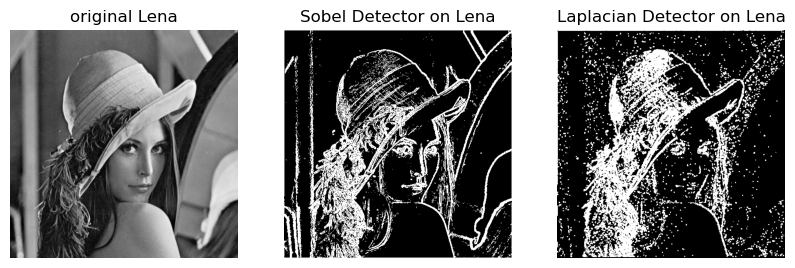

In [28]:
lena = np.array(Image.open('img/lena.png'))
Ix, Iy, Ig1, lenaSobel = SobelDetector(lena, 70)
lenaLap = LaplacianDetector(lena, 70)

fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 1
columns = 3
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(lena)
plt.axis('off')
plt.title("original Lena")

  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(lenaSobel)
plt.axis('off')
plt.title("Sobel Detector on Lena")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(lenaLap)
plt.axis('off')
plt.title("Laplacian Detector on Lena")

Both the Sobel Detector and the Laplacian Detector aim to detect and highlight the edges of an image, thus allowing to highlight its structure by removing an amount of information it contains, just to keep the "skeleton" of the picture.

Both the gradient based edge detector and the Laplacian based edge detector take advantage of convolution for edge analysis.
While Sobel works with the first derivative of the function, Laplacian works with the second derivative. 
Therefore Sobel measures the slope, while Laplacian measures the change of the slope

An operational difference between the two is given by the fact that the Laplacian Detector only works with one kernel, while the Sobel Detector executes its analysis with two kernels.
By doing so, the Sobel Detector analyzes the picture in both horizontal and vertical direction.

We can observe by the pictures above that the output obtained by this two kinds of studies are very different:

- with the Sobel Detector we are working on the gradient of a picture - since we know that an "edge ⇔ abrupt variation of intensities", edges correpond to the parts of the picture with the most significant response to derivatives. We localize this way the edges of the picture.       

- with the Laplacian Detector, on the other hand, we study the pixel of the image where the zero-crossing occurs - so we are looking at the second derivate of the convolution between the image and the Laplacian matrix, which means, looking at it with a graphical method, that it takes in consideration all the pixels where there is a slope change.                                  This makes the detector extremely sensitive to noise - as it can be seen from the picture above, where the edges are less smooth in comparison to the Sobel Detector.                                                                                  One possible solution to solve this problem is to reduce the noise in the picture before applying the Laplacian Detector, for example with a Gaussian Blur.


## Exercice 2: Non maximum suppression

This exercice addresses the problem of a unique localization of edges from a map determined by first order filters. This can be obtained by applying a non maximum suppression technique: the norm of an edge gradient should be maxima in the direction of the gradient. To this end, we provide the function `orientation(Ix,Iy,Ig)` that determines from spatial derivatives $I_x$, $I_y$ (using your favorite filters) and the gradient norm $I_g$ the orientation of the gradient for each pixels. Possible orientations are $0$, $\frac\pi4$, $\frac\pi2$ and $\frac{3\pi}4$ respectively coded by values 1, 2, 3 and 4 (0 stands for null gradient). Orientation of gradient are determined in the direct orthonormal basis.

1. Display the output of function `orientation()` applied on image `img/tools.png`. Verify values according to the different local orientation configurations (use `imshow_hot()` in interactive mode in the nootebook to see pixels value pointed by the mouse screen).

<IPython.core.display.Javascript object>


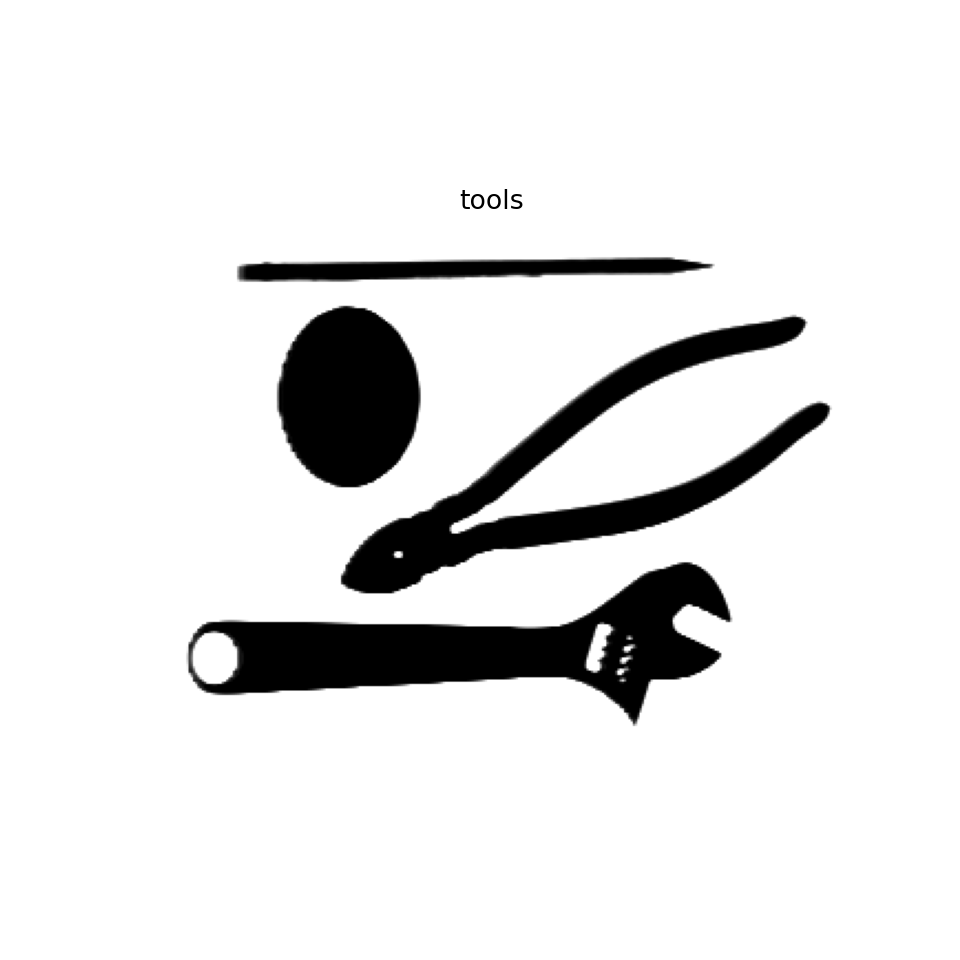

<IPython.core.display.Javascript object>


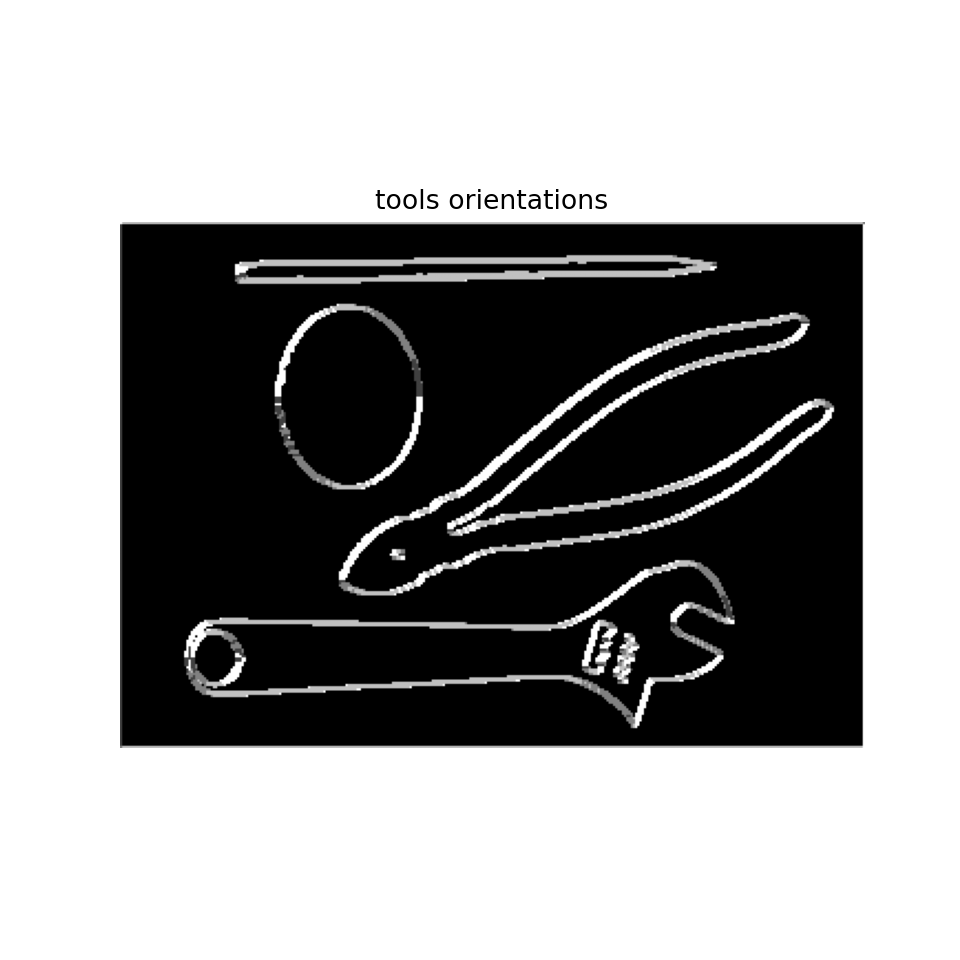

<IPython.core.display.Javascript object>


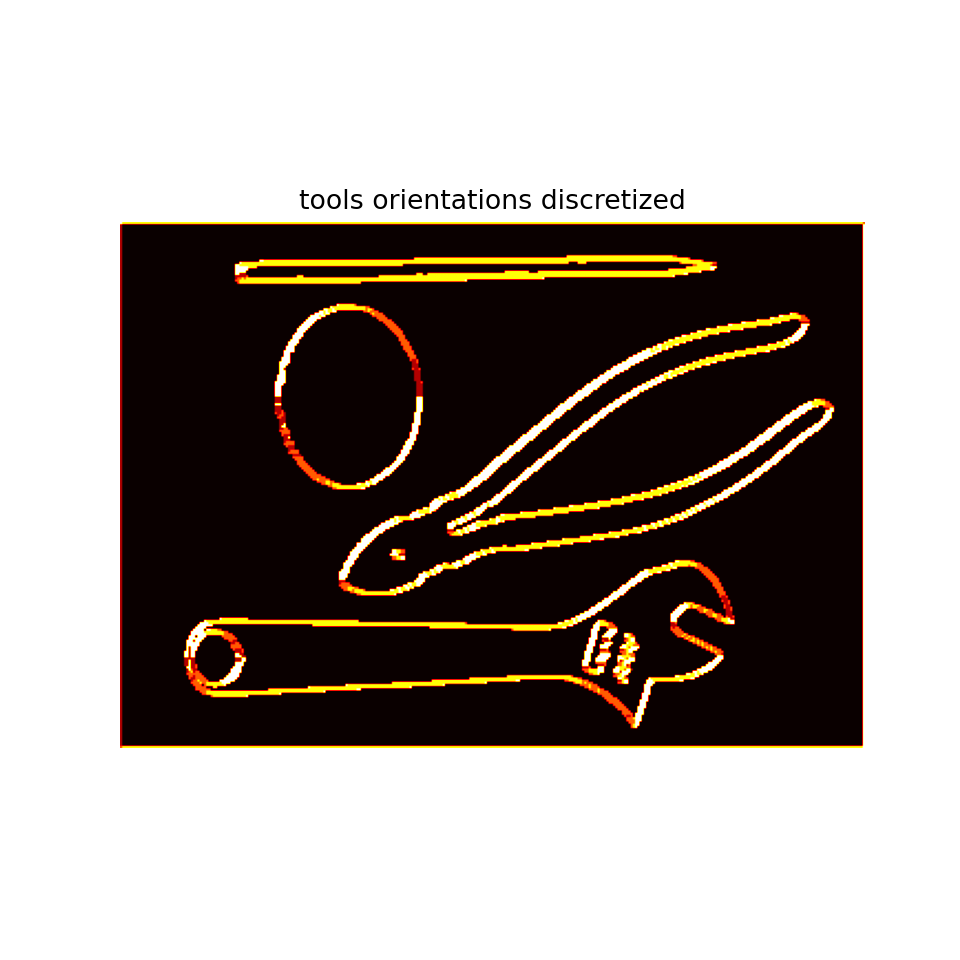

In [45]:
%matplotlib notebook
#### your answer below 

tools = np.array(Image.open('img/tools.png'))
imshow(tools, title='tools')

Ix, Iy, Ig1, Ig = SobelDetector(tools, 70)
imshow(orientation(Ix, Iy, Ig), title='tools orientations')

imshow_hot(orientation(Ix, Iy, Ig), title='tools orientations discretized')



Explain the different values given to a pixel by `orientation()`:

In this exercise I used the orientation() function provided, which allows us to discretize the orientation values assumed by the pixels' gradient.

Specifically, in this exercise there are 4 possible bins, as can be seen from the third image, where we see appearing in the figure 4 colors corresponding to the different orientations of the pixels in the image.

For example, the pencil at the top of the figure is lying down, its constituent pixels are all approximately oriented the same way and therefore as a result of discretization they are all in yellow color.

1: horizontal

2: first diagonal

3: vertical

4: second diagonal

0: no gradient orientation


2. Write a function `G=nms(Ig, Ior)` getting the gradient norm of an image, and the gradient orientation and returning an image of norm gradient for pixels being a local maxima of gradient norm in the direction of gradient or 0 otherwise. In other words, pixel `(i,j)` is a local maxima if `G[i,j] > 0` and `G[i,j]` gives the gradient norm value at this pixel.

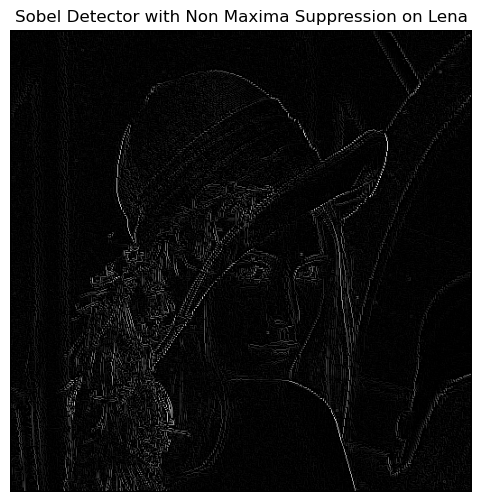

figure1


In [60]:
def nms(Ig, Ior):
    """ Array**2 -> Array """
    nmsArray = np.zeros((Ig.shape[0], Ig.shape[1]))
    
    for i in range(1, Ig.shape[0]-1):
        for j in range(1, Ig.shape[1]-1):
            
            if Ior[i][j] == 1 and Ig[i][j] > Ig[i][j-1] and Ig[i][j] > Ig[i][j+1]: nmsArray[i][j] = Ig[i][j] 
                    
            elif Ior[i][j] == 2 and Ig[i][j] > Ig[i-1][j-1] and Ig[i][j] > Ig[i+1][j+1]: nmsArray[i][j] = Ig[i][j] 
                    
            elif Ior[i][j] == 3 and Ig[i][j] > Ig[i-1][j] and Ig[i][j] > Ig[i+1][j]: nmsArray[i][j] = Ig[i][j] 
                    
            elif Ior[i][j] == 4 and Ig[i][j] > Ig[i-1][j+1] and Ig[i][j] > Ig[i+1][j-1]: nmsArray[i][j] = Ig[i][j] 
                   
            else: Ig[i][j] = 0
            
    return nmsArray

             
Ix_lena, Iy_lena, Ig1_lena, Ig_lena = SobelDetector(lena, 70) 
Ior_lena = orientation(Ix_lena, Iy_lena, Ig1_lena)

imshow(nms(Ig1_lena, Ior_lena), title='Sobel Detector with Non Maxima Suppression on Lena' )
print("figure1")

3. Experiments function `nms()` on images `img/tools.png` and `img/lena.png` after apply or not a gaussian filter (use the function `gaussianKernel()` given in the previous TME).


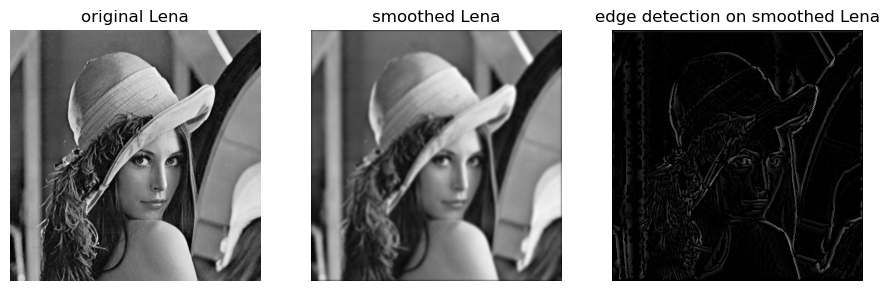

figure2


In [48]:
%matplotlib inline
### your answer below
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()

def gaussianConv(I, sigma):
    kernel = gaussianKernel(sigma)
    image = np.array(I)
    
    filtered_image = convolve2d(image, kernel, 'same')
            
    return filtered_image


lenaGauss = gaussianConv(lena, ((15-1)/6))

Ix, Iy, Ig1, Ig = SobelDetector(lenaGauss, 70)  
Ior = orientation(Ix, Iy, Ig1)
nmsLena = nms(Ig1, Ior)

#
fig = plt.figure(figsize=(11, 8))
  
# setting values to rows and column variables
rows = 1
columns = 3
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(lena)
plt.axis('off')
plt.title("original Lena")

  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(lenaGauss)
plt.axis('off')
plt.title("smoothed Lena")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(nmsLena)
plt.axis('off')
plt.title("edge detection on smoothed Lena")
plt.show()
print("figure2")

4. Conclude on the effect of smoothing (value of $\sigma$) on the edge detection process and on the size of edges.

As we can see by comparing the result of edge detection with non maxima suppression on the original picture of Lena (figure1) and the result of edge detection on a smoothed picture of Lena (figure2), when smoothing the picture the edges become less defined. 

This results in having thicker edges describing the image, with the output less constrained by small image noise, but on the other hand the output also loses accuracy

## Exercice 3:  Effects of smoothing in edge detection
Edge detectors are high pass filters and then amplify noise. To avoid this issue, we apply low pass filter, such as Gaussian filter, as preprocess. In this exercice, we use the image `img/lena.png`.

1. Smooth image `lena` by convolving with $G_\sigma$, the gaussian kernel of standard deviation $\sigma = 2$.

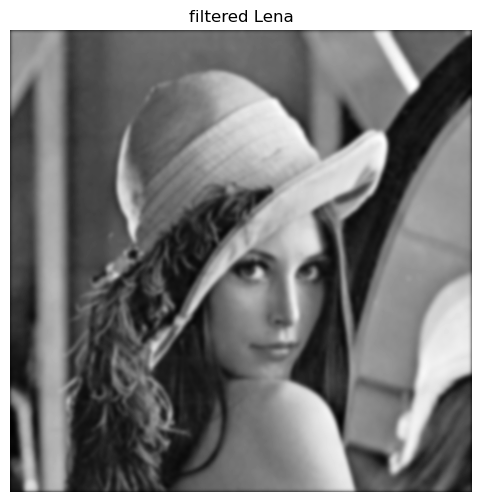

In [36]:
filteredLena = gaussianConv(lena, 2)
imshow(filteredLena, title='filtered Lena')

2. On the smoothed image apply Sobel and Laplacian edge detectors. Find threshold values (around 10 for Laplacian and 200 for Sobel) in order the two detectors approximately detect the same contours. After smoothing, what are the main difference between the two detectors.

Text(0.5, 1.0, 'Laplacian Detector on Filtered Lena')

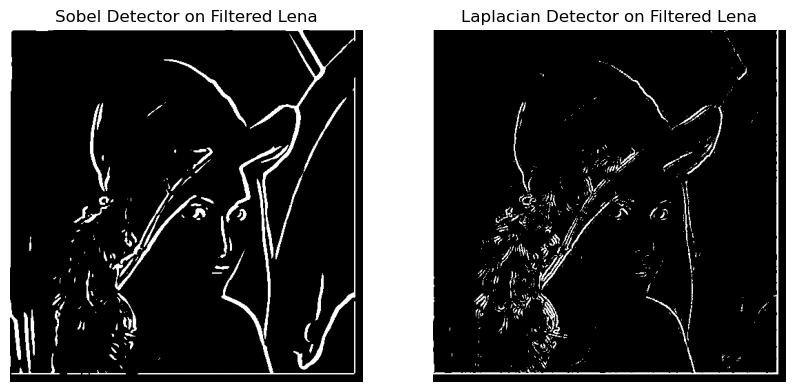

In [26]:
IxFiltered, IyFiltered, Ig1Filtered, IgFiltered = SobelDetector(filteredLena, 100)
#imshow(IgFiltered)

lenaLaplacian = LaplacianDetector(filteredLena, 10)
#imshow(lenaLaplacian)

fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 1
columns = 2
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(IgFiltered)
plt.axis('off')
plt.title("Sobel Detector on Filtered Lena")

  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(lenaLaplacian)
plt.axis('off')
plt.title("Laplacian Detector on Filtered Lena")

3. Let vary $\sigma\in[\sigma_1, \sigma_2]$ ($\sigma_1$ and $\sigma_2$ to be determined) and analyze results obtained for both detectors. What are the effects of smoothing on the noise ? on the localisation of contours ?



FILTERED LENA 3X3-------------------------------------------------------------------------------



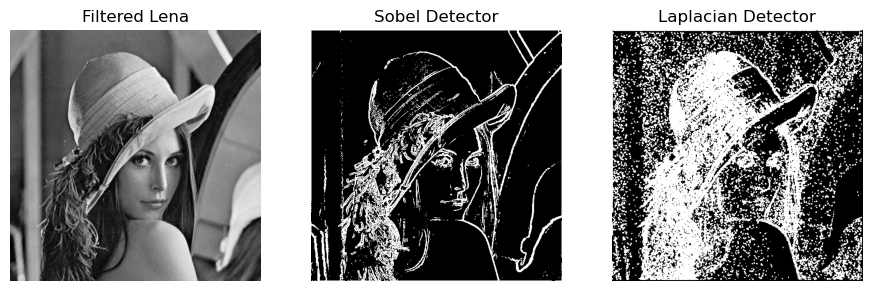



FILTERED LENA 7x7-------------------------------------------------------------------------------



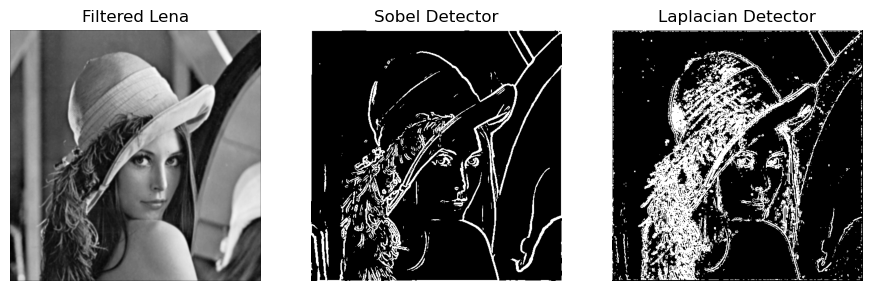



FILTERED LENA 13x13-------------------------------------------------------------------------------



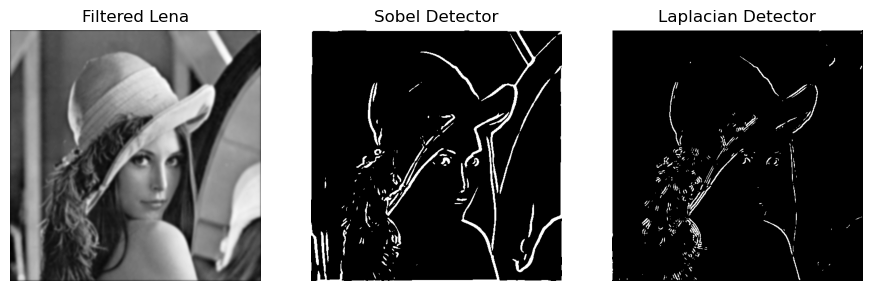

In [51]:
#sigma1 = 0.3333 (kernel 3x3)
#4x4
#5x5
#6x6
#sigma2 = 1 (kernel 7x7)

print('\n\nFILTERED LENA 3X3-------------------------------------------------------------------------------\n')
filteredLena1 = gaussianConv(lena, (3-1)/6)
IxFiltered1, IyFiltered1, Ig1Filtered1, IgFiltered1 = SobelDetector(filteredLena1, 100)
lenaLaplacian1 = LaplacianDetector(filteredLena1, 50)

fig = plt.figure(figsize=(11, 8))
  
# setting values to rows and column variables
rows = 1
columns = 3
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(filteredLena1)
plt.axis('off')
plt.title("Filtered Lena")

  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(IgFiltered1)
plt.axis('off')
plt.title("Sobel Detector")

  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
plt.imshow(lenaLaplacian1)
plt.axis('off')
plt.title("Laplacian Detector")
plt.show()

print('\n\nFILTERED LENA 7x7-------------------------------------------------------------------------------\n')
filteredLena3 = gaussianConv(lena, (7-1)/6)
IxFiltered3, IyFiltered3, Ig1Filtered3, IgFiltered3 = SobelDetector(filteredLena3, 100)
lenaLaplacian3 = LaplacianDetector(filteredLena3, 10)

fig = plt.figure(figsize=(11, 8))
  
# setting values to rows and column variables
rows = 1
columns = 3
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(filteredLena3)
plt.axis('off')
plt.title("Filtered Lena")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(IgFiltered3)
plt.axis('off')
plt.title("Sobel Detector")

  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
plt.imshow(lenaLaplacian3)
plt.axis('off')
plt.title("Laplacian Detector")
plt.show()


print('\n\nFILTERED LENA 13x13-------------------------------------------------------------------------------\n')
filteredLena2 = gaussianConv(lena, (13-1)/6)
IxFiltered2, IyFiltered2, Ig1Filtered2, IgFiltered2 = SobelDetector(filteredLena2, 100)
lenaLaplacian2 = LaplacianDetector(filteredLena2, 10)

fig = plt.figure(figsize=(11, 8))
  
# setting values to rows and column variables
rows = 1
columns = 3
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(filteredLena2)
plt.axis('off')
plt.title("Filtered Lena")

  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(IgFiltered2)
plt.axis('off')
plt.title("Sobel Detector")

  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
plt.imshow(lenaLaplacian2)
plt.axis('off')
plt.title("Laplacian Detector")
plt.show()


With this exercise we conduct two analyses in parallel: what changes in edge detection if we apply a Gaussian filter on the image (and what changes as the sigma of the filter changes) and what are the differences in this study between using the Edge Detector and the Laplacian Detector.

Concerning the Laplacian Detector, this is very sensitive to noise in the image, so much so that if we apply it on the raw image this has well defined the edges of the image but also many individual points of noise. 
By increasing the Gaussian filter all these noises manage to be eliminated, but it also loses a bit of edge precision. 
As we can see the optimal kernel for the Laplacian Detector in this study has size 7x7.

The Sobel Detector is less sensitive to noise than the Laplacian, although also here we get better results by applying a small filter.
We can see that by increasing the size of the kernel even slightly, sharp edges (which increase in thickness) become even more prominent with this filter, while less strong edges such as those of Lena's nose or jaw disappear

4. Replace the gaussian filter by a constrast enhancer filter of impulse response $\begin{pmatrix} 0&-1&0\\-1&5&-1\\0&-1&0\end{pmatrix}$ (other choices are possible). Discuss the results.

Text(0.5, 1.0, 'Laplacian on enhanced Lena')

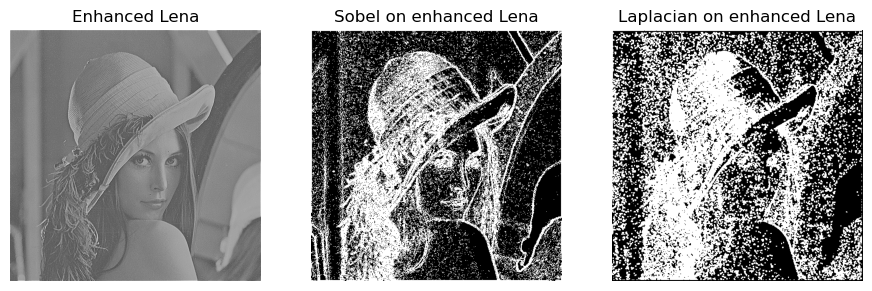

In [57]:
def contrastEnhancer(I):
    
    image = np.array(I)
    enhancer = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]])
    
      
    O = convolve2d(image, enhancer, 'same')
     
    return O

enhancedLena = contrastEnhancer(lena)

IxEnhanced, IyEnhanced, Ig1Enhanced, IgEnhanced = SobelDetector(enhancedLena, 100)

lenaEnhanced = LaplacianDetector(enhancedLena, 300)

#
fig = plt.figure(figsize=(11, 8))
  
# setting values to rows and column variables
rows = 1
columns = 3
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(enhancedLena)
plt.axis('off')
plt.title("Enhanced Lena")

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(IgEnhanced)
plt.axis('off')
plt.title("Sobel on enhanced Lena")

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(lenaEnhanced)
plt.axis('off')
plt.title("Laplacian on enhanced Lena")



This exercise asked to perform edge detection analysis on Lena's photo to which a contrast enhancer filter had previously been applied. 

As we can see from the output figures, this type of filter tends to flatten the differences in values between noncontour pixels, as 4 coefficients around the considered pixel have negative sign.
Therefore, the analyses done by edge detectors show much more noise

This is because we can distinguish two cases of pixels whose value is increased by this filter:
- pixels that belong to the edges of the figure

- some noise pixels, that are usually masked by filters such as Gaussian, here are multiplied by a factor of 5. By the definition of noise pixel, we know that their value is much higher than the one of their neighbour pixels, so even with this four neighbours subtracted, as a result of this filter this noise pixels are accentuated.                              Therefore, when doing edge detection with this filter, we capture more "noisy" pixels

5. Apply a multiresolution decomposition up to a size $8\times8$. Apply the two detectors for each resolution. Discuss the results.

In [37]:
def subSample2(I):
    """ Array -> Array """
    return I[::2,::2]

First iteration of subsampling - 256x256


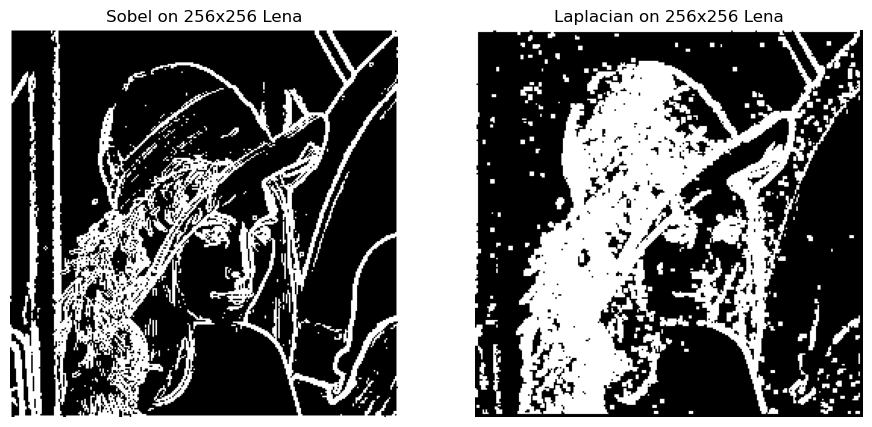

Second iteration of subsampling - 128x128


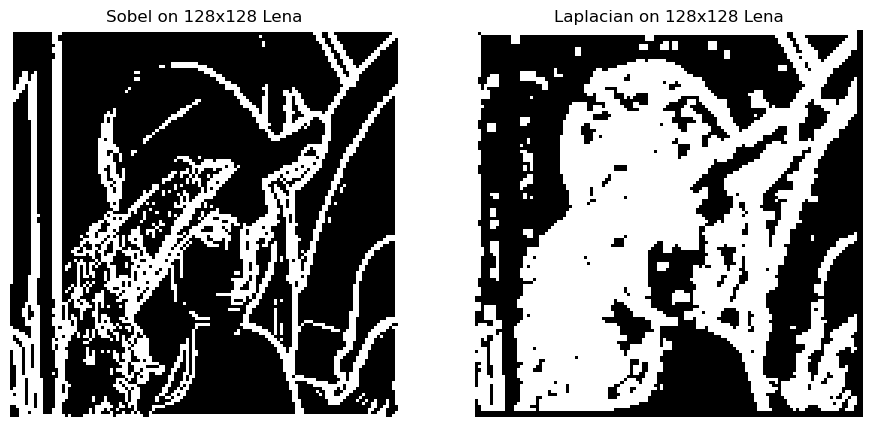

Third iteration of subsampling - 64x64


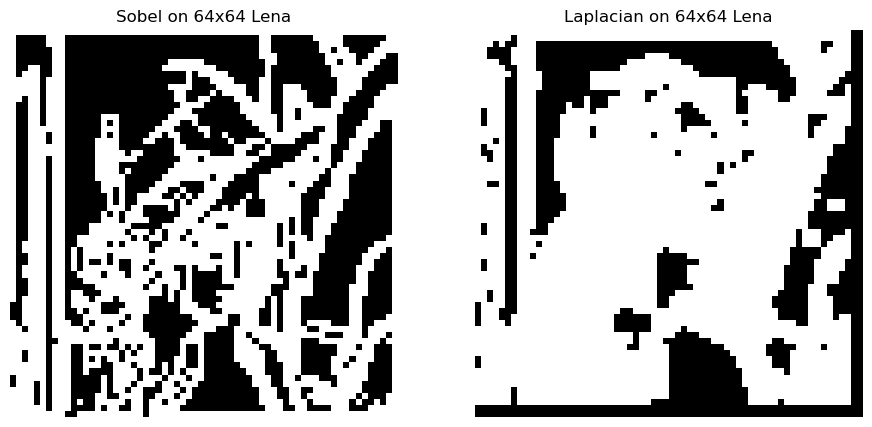

Fourth iteration of subsampling - 32x32


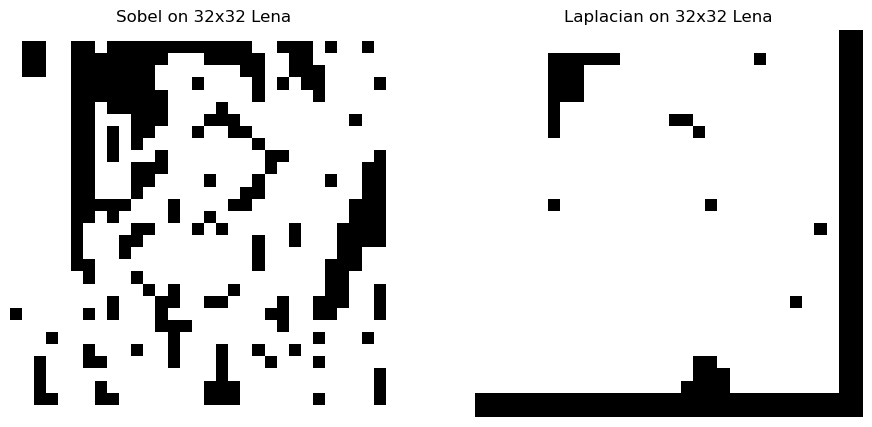

Fifth iteration of subsampling - 16x16


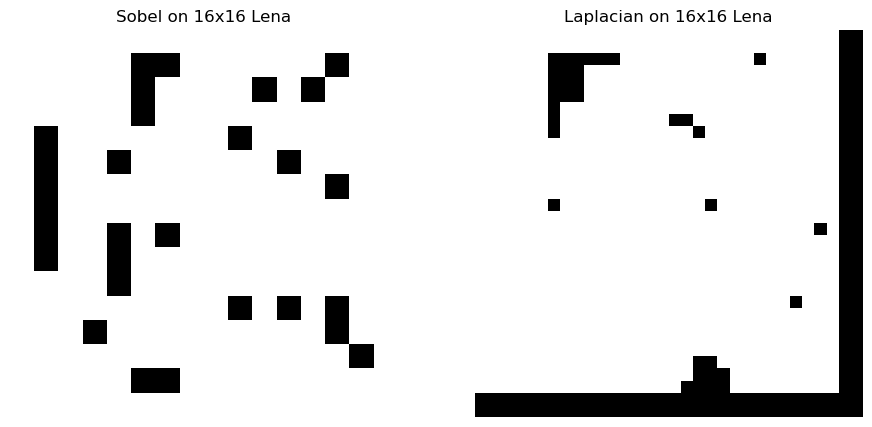

Sixth iteration of subsampling - 8x8


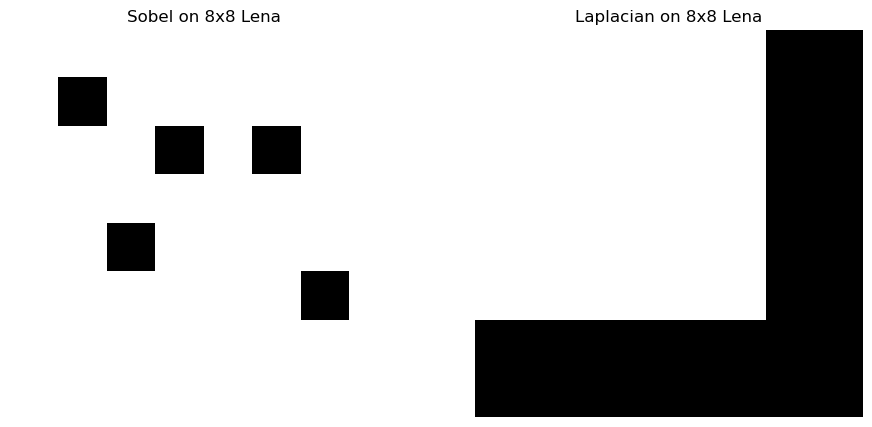

In [58]:
print('First iteration of subsampling - 256x256')
l1 = subSample2(gaussianConv(lena, (3-1)/6))
IxSub2, IySub2, Ig1Sub2, IgSub2 = SobelDetector(l1, 100)
lenaSub2 = LaplacianDetector(l1, 80)

fig = plt.figure(figsize=(11, 8))
rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
  
plt.imshow(IgSub2)
plt.axis('off')
plt.title("Sobel on 256x256 Lena")

fig.add_subplot(rows, columns, 2)

plt.imshow(lenaSub2)
plt.axis('off')
plt.title("Laplacian on 256x256 Lena")
plt.show()

#-----------------------------------
print('Second iteration of subsampling - 128x128')
l2= subSample2(gaussianConv(l1, (3-1)/6))
IxSub4, IySub4, Ig1Sub4, IgSub4 = SobelDetector(l2, 150)
lenaSub4 = LaplacianDetector(l2, 80)

fig = plt.figure(figsize=(11, 8))
rows = 1
columns = 2
  
fig.add_subplot(rows, columns, 1)
  
plt.imshow(IgSub4)
plt.axis('off')
plt.title("Sobel on 128x128 Lena")

fig.add_subplot(rows, columns, 2)

plt.imshow(lenaSub4)
plt.axis('off')
plt.title("Laplacian on 128x128 Lena")
plt.show()

#---------------------------------------------------------
print('Third iteration of subsampling - 64x64')
l3 = subSample2(gaussianConv(l2, (3-1)/6))
IxSub8, IySub8, Ig1Sub8, IgSub8 = SobelDetector(l3, 100)
lenaSub8 = LaplacianDetector(l3, 80)

fig = plt.figure(figsize=(11, 8))
rows = 1
columns = 2
  
fig.add_subplot(rows, columns, 1)
  
plt.imshow(IgSub8)
plt.axis('off')
plt.title("Sobel on 64x64 Lena")

fig.add_subplot(rows, columns, 2)

plt.imshow(lenaSub8)
plt.axis('off')
plt.title("Laplacian on 64x64 Lena")
plt.show()

#-----------------------------------------------
print('Fourth iteration of subsampling - 32x32')
l4 = subSample2(gaussianConv(l3, (3-1)/6))
IxSub16, IySub16, Ig1Sub16, IgSub16 = SobelDetector(l4, 100)
lenaSub16 = LaplacianDetector(l4, 80)

fig = plt.figure(figsize=(11, 8))
rows = 1
columns = 2
  
fig.add_subplot(rows, columns, 1)
  
plt.imshow(IgSub16)
plt.axis('off')
plt.title("Sobel on 32x32 Lena")

fig.add_subplot(rows, columns, 2)

plt.imshow(lenaSub16)
plt.axis('off')
plt.title("Laplacian on 32x32 Lena")
plt.show()

#--------------------------------------------------------
print('Fifth iteration of subsampling - 16x16')
l5 = subSample2(gaussianConv(l4, (3-1)/6))
IxSub32, IySub32, Ig1Sub32, IgSub32 = SobelDetector(l5, 100)
lenaSub32 = LaplacianDetector(l4, 80)

fig = plt.figure(figsize=(11, 8))
rows = 1
columns = 2
  
fig.add_subplot(rows, columns, 1)
  
plt.imshow(IgSub32)
plt.axis('off')
plt.title("Sobel on 16x16 Lena")

fig.add_subplot(rows, columns, 2)

plt.imshow(lenaSub32)
plt.axis('off')
plt.title("Laplacian on 16x16 Lena")
plt.show()


#-------------------------------------------------
print('Sixth iteration of subsampling - 8x8')
l6 = subSample2(gaussianConv(l5, (3-1)/6))
IxSub64, IySub64, Ig1Sub64, IgSub64 = SobelDetector(l6, 100)
lenaSub64 = LaplacianDetector(l6, 80)

fig = plt.figure(figsize=(11, 8))
rows = 1
columns = 2
  
fig.add_subplot(rows, columns, 1)
  
plt.imshow(IgSub64)
plt.axis('off')
plt.title("Sobel on 8x8 Lena")

fig.add_subplot(rows, columns, 2)

plt.imshow(lenaSub64)
plt.axis('off')
plt.title("Laplacian on 8x8 Lena")
plt.show()



In the latter exercise, it was required to study the Lena image through the output of the Sobel Detector and the Laplacian Detector, following successive sub-sampling iterations.

In order to perform this type of analysis, I applied Gaussian filtering to the image before each sub-sampling iteration to avoid the occurrence of aliasing. 

As can be seen from the output produced, half of the information contained in the image is lost with each sub-sampling. Actually through the application of the Gaussian filter, a little less information is lost, because the contours of the image are more blurred and therefore the edge detector can still detect them, although thicker and less accurate. 

We see from the output of the iterations that the detectors lose ability to detect the contours by the time the image has size 64x64 (third iteration - information content 1/8 of the original), which demonstrates the power of these detectors